In [1]:
# Core Libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
import pandas as pd
import os

# Load and clean CSV
df = pd.read_csv("Labels.csv")

# Strip spaces and fix column names
df.columns = df.columns.str.strip()
df["Label"] = df["Label"].str.strip().str.upper()

# Map labels: GON+ → 1 (Glaucoma), GON- → 0 (Normal)
label_map = {"GON+": 1, "GON-": 0}
df = df[df["Label"].isin(label_map.keys())]  # Filter unexpected values
df["label"] = df["Label"].map(label_map)

# Create list of (image_path, label)
image_dir = "Images"
image_label_list = [
    (os.path.join(image_dir, fname), label)
    for fname, label in zip(df["Image Name"], df["label"])
    if os.path.exists(os.path.join(image_dir, fname))
]

print(f"Total labeled images found: {len(image_label_list)}")

Total labeled images found: 747


In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Stratified train-val split (80-20)
train_split, val_split = train_test_split(
    image_label_list,
    test_size=0.2,
    stratify=[label for _, label in image_label_list],
    random_state=42
)

print(f"Train samples: {len(train_split)}, Val samples: {len(val_split)}")

# Custom dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

Train samples: 597, Val samples: 150


In [7]:
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = GlaucomaDataset(train_split, transform=train_transform)
val_dataset = GlaucomaDataset(val_split, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [8]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Load EfficientNet with pretrained weights
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)

# Replace final classification layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Push model to device
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\bhara/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 57.1MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

EPOCHS = 100
PATIENCE = 7

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
all_val_preds_by_epoch = []
all_val_labels_by_epoch = []

best_val_loss = float("inf")
best_weights = None
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    epoch_val_preds, epoch_val_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            epoch_val_preds.extend(preds.cpu().numpy())
            epoch_val_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    all_val_preds_by_epoch.append(epoch_val_preds)
    all_val_labels_by_epoch.append(epoch_val_labels)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.2f}% | Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_weights = model.state_dict()
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            break

model.load_state_dict(best_weights)
torch.save(best_weights, "best_glaucoma_model.pth")

Epoch 1/100: 100%|██████████| 19/19 [00:18<00:00,  1.01it/s]


Epoch 1: Train Loss = 0.5691, Train Acc = 74.87% | Val Loss = 0.4566, Val Acc = 83.33%


Epoch 2/100: 100%|██████████| 19/19 [00:18<00:00,  1.05it/s]


Epoch 2: Train Loss = 0.2916, Train Acc = 92.63% | Val Loss = 0.2172, Val Acc = 90.67%


Epoch 3/100: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


Epoch 3: Train Loss = 0.1466, Train Acc = 95.98% | Val Loss = 0.1128, Val Acc = 96.00%


Epoch 4/100: 100%|██████████| 19/19 [00:18<00:00,  1.02it/s]


Epoch 4: Train Loss = 0.1094, Train Acc = 96.48% | Val Loss = 0.0935, Val Acc = 97.33%


Epoch 5/100: 100%|██████████| 19/19 [00:17<00:00,  1.06it/s]


Epoch 5: Train Loss = 0.0914, Train Acc = 96.82% | Val Loss = 0.0919, Val Acc = 97.33%


Epoch 6/100: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]


Epoch 6: Train Loss = 0.0753, Train Acc = 97.65% | Val Loss = 0.1082, Val Acc = 95.33%


Epoch 7/100: 100%|██████████| 19/19 [00:16<00:00,  1.15it/s]


Epoch 7: Train Loss = 0.0581, Train Acc = 97.99% | Val Loss = 0.0719, Val Acc = 98.00%


Epoch 8/100: 100%|██████████| 19/19 [00:16<00:00,  1.17it/s]


Epoch 8: Train Loss = 0.0457, Train Acc = 98.83% | Val Loss = 0.0625, Val Acc = 99.33%


Epoch 9/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 9: Train Loss = 0.0265, Train Acc = 99.50% | Val Loss = 0.0446, Val Acc = 99.33%


Epoch 10/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 10: Train Loss = 0.0241, Train Acc = 99.66% | Val Loss = 0.0414, Val Acc = 99.33%


Epoch 11/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 11: Train Loss = 0.0239, Train Acc = 99.50% | Val Loss = 0.0306, Val Acc = 99.33%


Epoch 12/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 12: Train Loss = 0.0232, Train Acc = 99.50% | Val Loss = 0.0589, Val Acc = 99.33%


Epoch 13/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 13: Train Loss = 0.0203, Train Acc = 99.33% | Val Loss = 0.0496, Val Acc = 99.33%


Epoch 14/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 14: Train Loss = 0.0329, Train Acc = 99.16% | Val Loss = 0.0635, Val Acc = 99.33%


Epoch 15/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 15: Train Loss = 0.0233, Train Acc = 99.16% | Val Loss = 0.0462, Val Acc = 98.67%


Epoch 16/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 16: Train Loss = 0.0143, Train Acc = 100.00% | Val Loss = 0.0499, Val Acc = 98.67%


Epoch 17/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 17: Train Loss = 0.0130, Train Acc = 99.83% | Val Loss = 0.0830, Val Acc = 98.00%


Epoch 18/100: 100%|██████████| 19/19 [00:15<00:00,  1.25it/s]


Epoch 18: Train Loss = 0.0073, Train Acc = 99.83% | Val Loss = 0.0691, Val Acc = 98.67%


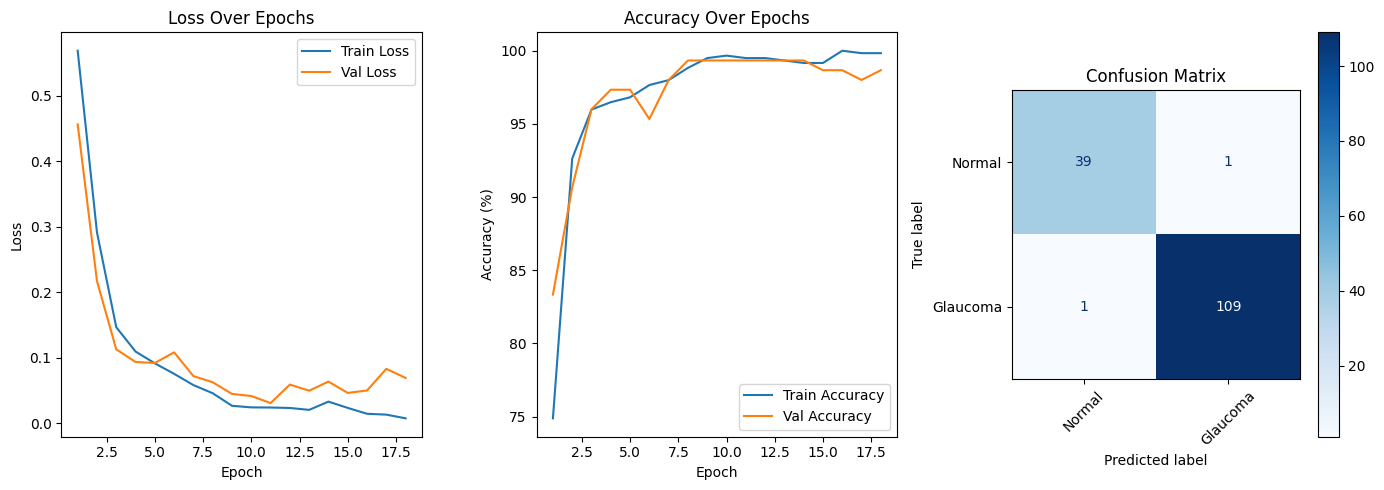

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Epochs")
plt.legend()

# Confusion matrix from last epoch
plt.subplot(1, 3, 3)
cm = confusion_matrix(all_val_labels_by_epoch[-1], all_val_preds_by_epoch[-1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Glaucoma"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.xticks(rotation=45)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("glaucoma_results.png")
plt.show()

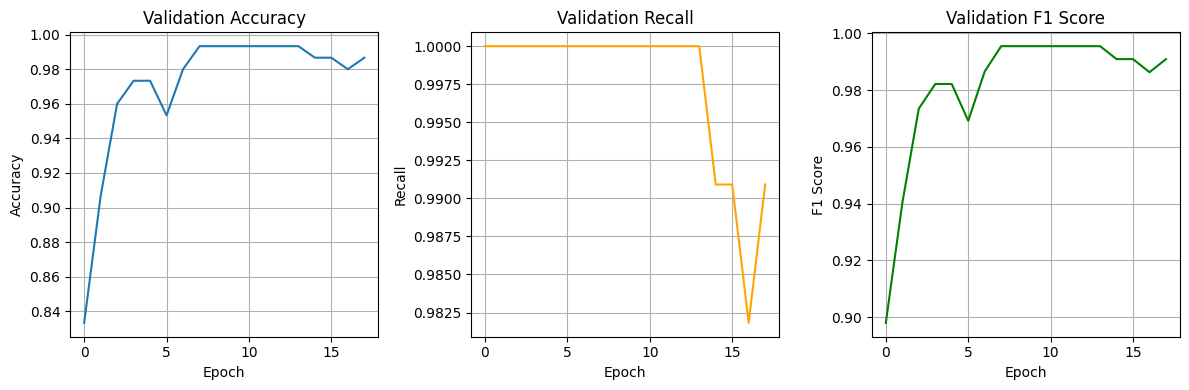

In [11]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

val_metrics = {
    "accuracy": [],
    "recall": [],
    "f1_score": []
}

# Compute metrics per epoch
for preds, labels in zip(all_val_preds_by_epoch, all_val_labels_by_epoch):
    val_metrics["accuracy"].append(accuracy_score(labels, preds))
    val_metrics["recall"].append(recall_score(labels, preds))
    val_metrics["f1_score"].append(f1_score(labels, preds))

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(val_metrics["accuracy"], label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_metrics["recall"], label="Recall", color="orange")
plt.title("Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(val_metrics["f1_score"], label="F1 Score", color="green")
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()